In [1]:
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [4]:
source = 'test_results_2018-07-25'
verbose = False

In [5]:
# Loop through tests, loading results into lists of dictionaries
tests = ['test1', 'test2', 'test3', 'test4']

models = ['ssd_mobilenet_v1_coco',
          'sd_mobilenet_v2_coco',
          'ssdlite_mobilenet_v2_coco',
          'ssd_inception_v2_coco',
          'faster_rcnn_inception_v2_coco',
          'faster_rcnn_resnet50_coco',
          'faster_rcnn_resnet50_lowproposals_coco',
          'faster_rcnn_resnet101_coco',
          'faster_rcnn_resnet101_lowproposals_coco',
          'mask_rcnn_inception_v2_coco']

models_short = ['ssd_mobilenet_v1',
          'sd_mobilenet_v2',
          'ssdlite_mobilenet_v2',
          'ssd_inception_v2',
          'f_rcnn_inception_v2',
          'f_rcnn_resnet50',
          'f_rcnn_resnet50_lp',
          'f_rcnn_resnet101',
          'f_rcnn_resnet101_lp',
          'mask_rcnn_inception_v2']

In [9]:
gt_path = 'detections.csv'

with open(gt_path, 'r') as f:
  reader = csv.reader(f)
  gt_raw = list(reader)
    
def fill_blanks(_item):
    if _item is '':
        return 0
    return int(_item)

gts = []
for test in tests:
    if verbose:
        print('\n\t> {}'.format(test))
    gt = []
    for g in gt_raw[1:]:  # ignore header
        if g[0] == test:
            result = [fill_blanks(r) for r in g[1:]]
            gt.append(result)
            if verbose:
                print(result)
    gts.append(gt)

In [5]:
np.shape(gts)

(4, 100, 5)

In [6]:
# extract results
results = []
for test in tests:
    if verbose:
        print('\n> {}'.format(test))
    test_results = []
    for model in models:
        if verbose:
            print('\t> {}'.format(model))
        path = os.path.join(source, test + '_' + model + '.npy')
        model_results = np.load(path)
        if verbose:
            print('\t\t> {} detections'.format(len(model_results)))
        test_results.append(model_results)
    results.append(test_results)

In [7]:
# calculate detection rate TP/(TP+FN)
# model
#    test
#        frame

all_detection_rate_results = []
all_av_detection_rate_results = []
model_summary = []

for m, model in enumerate(models):

    detection_rate_results = []
    av_detection_rate_results = []

    for test, test_gt, test_results in zip(tests, gts, results):
        if verbose:
            print('\n\t>{}'.format(test))

        test_gt_full = []
        test_gt_partial = []
        test_gt_heavy = []
        test_gt_all = []
        
        test_detections = []
        test_detection_full = []
        test_detection_partial = []
        test_detection_heavy = []
        
        test_detection_rates = []
        test_detection_rates_full = []
        test_detection_rates_partial = []
        test_detection_rates_heavy = []

        model_results = test_results[m]
        if verbose:
            print('> Model: {}'.format(model))

        for gt in test_gt:

            gt_full = int(gt[2])
            gt_partial = int(gt[3])
            gt_heavy = int(gt[4])
            gt_all = int(gt[2]) + int(gt[3]) + int(gt[4])
            
            true_possitives = 0
            if gt_all:  # ignores empty frames
                # Check for all results with same frame id
                for model_result in model_results:
                    if int(model_result[0]) == int(gt[1]):
                        true_possitives += 1

                test_gt_all.append(gt_all)
                test_gt_full.append(gt_full)
                test_gt_partial.append(gt_partial)
                test_gt_heavy.append(gt_heavy)
                
                detection_full = min(true_possitives, gt_full)
                detection_partial = min(true_possitives - detection_full, gt_partial)
                detection_heavy = min(true_possitives - detection_full - detection_partial, gt_heavy)
                
                test_detections.append(true_possitives)
                test_detection_full.append(detection_full)
                test_detection_partial.append(detection_partial)
                test_detection_heavy.append(detection_heavy)
                
                test_detection_rates.append(true_possitives/gt_all)
                test_detection_rates_full.append(detection_full/gt_all)
                test_detection_rates_partial.append(detection_partial/gt_all)
                test_detection_rates_heavy.append(detection_heavy/gt_all)
                
            if verbose:
                print('{} gt detection > {} model detections'.format(gt_all, true_possitives))

        if test_gt_all:
            test_gt_all = np.array(test_gt_all)
            test_gt_full = np.array(test_gt_full)
            test_gt_partial = np.array(test_gt_partial)
            test_gt_heavy = np.array(test_gt_heavy)
            
            test_detections = np.array(test_detections)
            test_detection_full = np.array(test_detection_full)
            test_detection_partial = np.array(test_detection_partial)
            test_detection_heavy = np.array(test_detection_heavy)
            
            test_detection_rates = np.array(test_detection_rates)
            test_detection_rates_full = np.array(test_detection_rates_full)
            test_detection_rates_partial = np.array(test_detection_rates_partial)
            test_detection_rates_heavy = np.array(test_detection_rates_heavy) 
            
            test_detection_rate_results = (test_gt_all, test_detections, test_detection_rates)
            
            av_detection_rate_all = sum(test_detections) / sum(test_gt_all)
            av_detection_rate_full = sum(test_detection_full) / sum(test_gt_all)
            av_detection_rate_partial = sum(test_detection_partial) / sum(test_gt_all)
            av_detection_rate_heavy = sum(test_detection_heavy) / sum(test_gt_all)
            
            test_av_det_rate_results = (av_detection_rate_all, av_detection_rate_full, av_detection_rate_partial, av_detection_rate_heavy)
            
            detection_rate_results.append(test_detection_rate_results)
            av_detection_rate_results.append(test_av_det_rate_results)
            
    model_summary.append(sum(test_detections) / sum(test_gt_all))
            
    all_detection_rate_results.append(detection_rate_results)
    all_av_detection_rate_results.append(av_detection_rate_results)
 

In [8]:
model_summary

[0.23899059871350817,
 0.25630875804057396,
 0.24443344878772885,
 0.3008411677387432,
 0.5408213755566551,
 0.6095992083127165,
 0.4126669965363681,
 0.6180108857001484,
 0.49084611578426524,
 0.5863433943592281]

In [32]:
# Consider detection rates by frame
all_detection_rate_results_1 = all_detection_rate_results[:5]
all_detection_rate_results_2 = all_detection_rate_results[5:]

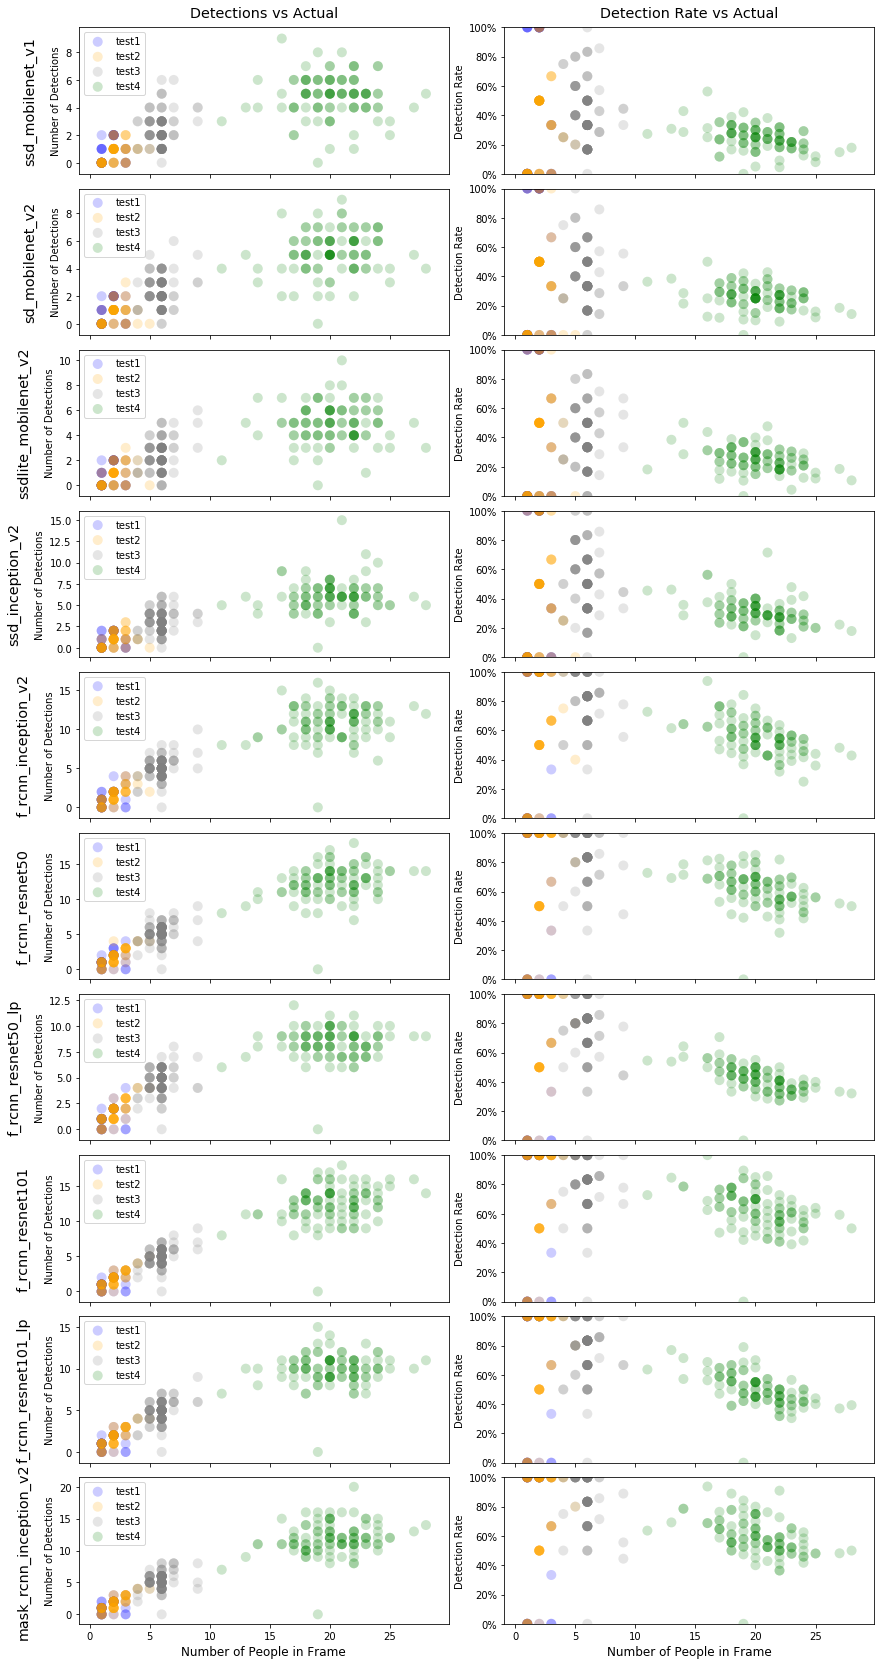

In [46]:
selection = all_detection_rate_results
colours = ("blue", "orange", "grey", "green")
titles = ['Detections vs Actual', 'Detection Rate vs Actual']
cols = 2
rows = len(selection)
fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True, figsize=(12, 2.3*rows))                        
for row, detection_rate_results in enumerate(selection):
    for detection_rate_result, color, test in zip(detection_rate_results, colours, tests):
        x, y1, y2 = detection_rate_result
        axes[row,0].scatter(x, y1, alpha=0.2, c=color, edgecolors='none', s=100, label=test)
        axes[row,1].scatter(x, y2, alpha=0.2, c=color, edgecolors='none', s=100, label=test)     
        axes[row,0].legend(loc=2)      
        axes[row,0].set_ylabel('Number of Detections')
        axes[row,1].set_ylim([0, 1])
        vals = axes[row,1].get_yticks()
        axes[row,1].set_yticklabels(['{:,.0%}'.format(x) for x in vals])
        axes[row,1].set_ylabel('Detection Rate')
axes[-1,0].set_xlabel('Number of People in Frame', size='large')
axes[-1,1].set_xlabel('Number of People in Frame', size='large')
pad = 10
for ax, title in zip(axes[0], titles):
    ax.annotate(title, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', ha='center', va='baseline')
for ax, model in zip(axes[:,0], models_short):
    ax.annotate(model, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='x-large', ha='right', va='center', rotation = 90)
fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.15, hspace=0.1)
plt.show()

In [45]:
#fig.savefig('figures/5_3a.png', bbox_inches='tight')
#fig.savefig('figures/5_3b.png', bbox_inches='tight')

In [12]:
model_summary

[0.23899059871350817,
 0.25630875804057396,
 0.24443344878772885,
 0.3008411677387432,
 0.5408213755566551,
 0.6095992083127165,
 0.4126669965363681,
 0.6180108857001484,
 0.49084611578426524,
 0.5863433943592281]

In [13]:
# Calculate detection rates at different occlusions

In [14]:
test_results = []
for t, test in enumerate(tests):
    model_results = []
    for model, model_result in zip(models_short, all_av_detection_rate_results):     
        test_result = model_result[t]
        model_results.append(test_result[0])
    test_results.append(model_results)
np.shape(test_results)

(4, 10)

In [15]:
d = {k: i for (k, i) in zip(tests, test_results)}
d['model'] = models_short
d['test_average'] = model_summary
df = pd.DataFrame(data=d)
df.set_index('model')
df

model     test1     test2     test3     test4  \
0        ssd_mobilenet_v1  0.490196  0.336283  0.404762  0.238991   
1         sd_mobilenet_v2  0.509804  0.353982  0.403061  0.256309   
2    ssdlite_mobilenet_v2  0.490196  0.389381  0.404762  0.244433   
3        ssd_inception_v2  0.509804  0.451327  0.518707  0.300841   
4     f_rcnn_inception_v2  0.764706  0.734513  0.853741  0.540821   
5         f_rcnn_resnet50  0.803922  0.823009  0.889456  0.609599   
6      f_rcnn_resnet50_lp  0.745098  0.796460  0.794218  0.412667   
7        f_rcnn_resnet101  0.725490  0.858407  0.848639  0.618011   
8     f_rcnn_resnet101_lp  0.725490  0.849558  0.819728  0.490846   
9  mask_rcnn_inception_v2  0.745098  0.831858  0.904762  0.586343   

   test_average  
0      0.238991  
1      0.256309  
2      0.244433  
3      0.300841  
4      0.540821  
5      0.609599  
6      0.412667  
7      0.618011  
8      0.490846  
9      0.586343

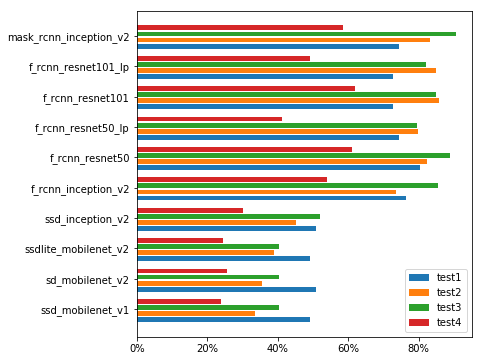

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(6,6))
ind = np.arange(10)    # the x locations for the groups
width = 0.16
spacing = 0.2
axes.barh(ind, df.test1, width, label=tests[0])
axes.barh(ind + spacing, df.test2, width, label=tests[1])
axes.barh(ind + (2*spacing), df.test3, width, label=tests[2])
axes.barh(ind + (3* spacing), df.test4, width, label=tests[3])

axes.set_yticks(ind + 0.34)
axes.set_yticklabels(df.model)
vals = axes.get_xticks()
axes.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
axes.legend()

plt.show()

In [17]:
# Consider by test

In [18]:
df_results = []
headers = ['none', 'partial', 'heavy']
for t, test in enumerate(tests):
    model_results = []
    full = []
    partial = []
    heavy = []
    for model, model_result in zip(models_short, all_av_detection_rate_results):     
        test_result = model_result[t]
        full.append(test_result[1])
        partial.append(test_result[2])
        heavy.append(test_result[3])
    all_results = (full, partial, heavy)
    d = {k: i for (k, i) in zip(headers, all_results)}
    d['model'] = models_short
    df = pd.DataFrame(data=d)
    df.set_index('model')
    df_results.append(df)


In [19]:
df_results[0]

heavy                   model      none   partial
0  0.058824        ssd_mobilenet_v1  0.333333  0.078431
1  0.078431         sd_mobilenet_v2  0.333333  0.078431
2  0.078431    ssdlite_mobilenet_v2  0.313725  0.078431
3  0.058824        ssd_inception_v2  0.333333  0.078431
4  0.215686     f_rcnn_inception_v2  0.372549  0.078431
5  0.235294         f_rcnn_resnet50  0.372549  0.098039
6  0.215686      f_rcnn_resnet50_lp  0.372549  0.098039
7  0.235294        f_rcnn_resnet101  0.372549  0.078431
8  0.235294     f_rcnn_resnet101_lp  0.372549  0.078431
9  0.215686  mask_rcnn_inception_v2  0.372549  0.098039

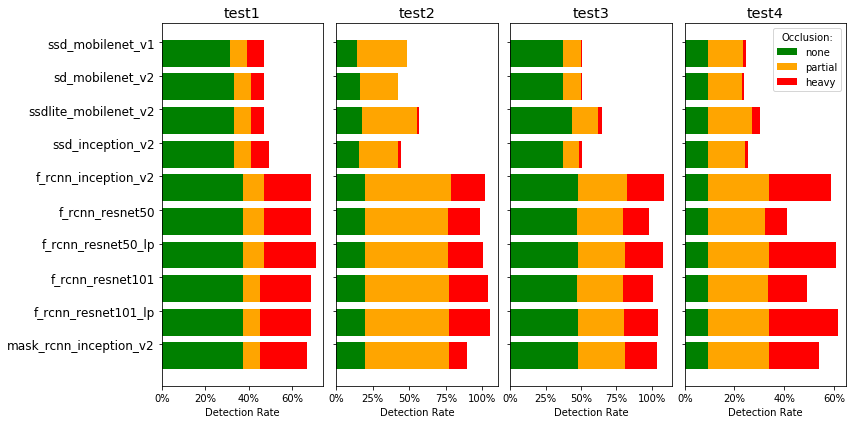

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=len(tests), sharey=True, figsize=(12,6))
ind = np.arange(10)    # the x locations for the groups
width = 0.16
spacing = 0.2
for col, (t, df_result) in enumerate(zip(tests, df_results)):
    axes[col].barh(df_result.model, df_result.none, label=headers[0], color='green')
    axes[col].barh(df_result.model, df_result.partial, label=headers[1], left=df_result.none, color='orange')
    axes[col].barh(df_result.model, df_result.heavy, label=headers[2], left=df_result.partial + df_result.none, color='red')

    axes[col].set_yticks(ind + 0.34)
    axes[col].set_yticklabels(df_result.model[::-1], size='large')
    vals = axes[col].get_xticks()
    axes[col].set_xticklabels(['{:,.0%}'.format(x) for x in vals])
    axes[col].set_xlabel('Detection Rate')
    axes[col].set_title(t, size='x-large')
axes[-1].legend(['none', 'partial', 'heavy'], title="Occlusion:")

fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.08, hspace=0)
plt.show()

In [67]:
#fig.savefig('figures/5_4.png', bbox_inches='tight')

In [21]:
test_results[1]

[0.336283185840708,
 0.35398230088495575,
 0.3893805309734513,
 0.45132743362831856,
 0.7345132743362832,
 0.8230088495575221,
 0.7964601769911505,
 0.8584070796460177,
 0.8495575221238938,
 0.831858407079646]

In [22]:
test_results[2]

[0.40476190476190477,
 0.4030612244897959,
 0.40476190476190477,
 0.5187074829931972,
 0.8537414965986394,
 0.8894557823129252,
 0.79421768707483,
 0.8486394557823129,
 0.8197278911564626,
 0.9047619047619048]

In [23]:
test_results[3]

[0.23899059871350817,
 0.25630875804057396,
 0.24443344878772885,
 0.3008411677387432,
 0.5408213755566551,
 0.6095992083127165,
 0.4126669965363681,
 0.6180108857001484,
 0.49084611578426524,
 0.5863433943592281]

In [24]:
results

[[array([[ 1.48070000e+04, -1.00000000e+00,  2.85230970e+02,
           1.91429257e+00,  1.19041443e+02,  2.78143959e+02,
           5.81134200e-01, -1.00000000e+00, -1.00000000e+00,
          -1.00000000e+00],
         [ 1.48170000e+04, -1.00000000e+00,  4.14272861e+02,
           0.00000000e+00,  6.99636841e+01,  1.33313749e+02,
           5.40454507e-01, -1.00000000e+00, -1.00000000e+00,
          -1.00000000e+00],
         [ 1.48400000e+04, -1.00000000e+00,  1.02390118e+02,
           1.83256459e+02,  4.08203487e+02,  3.50819163e+02,
           8.46546948e-01, -1.00000000e+00, -1.00000000e+00,
          -1.00000000e+00],
         [ 1.48480000e+04, -1.00000000e+00,  6.41261029e+01,
           7.83187866e+00,  1.43389814e+02,  3.33856423e+02,
           8.10304999e-01, -1.00000000e+00, -1.00000000e+00,
          -1.00000000e+00],
         [ 1.48810000e+04, -1.00000000e+00,  6.99774055e+02,
           8.92193270e+01,  1.80297089e+02,  4.42203290e+02,
           7.95615017e-01, -1.0000

In [25]:
# Consider locations

all_centre_results = []

for m, model in enumerate(models):
    if verbose:
            print('\n\t>{}'.format(model))
    
    model_centre_results = []
    
    for test, test_results in zip(tests, results):
        model_results = test_results[m]
        if verbose:
            print('\n>{}'.format(test))
        
        test_centre_x = []
        test_centre_y = []
        test_conf = []

        for result in model_results:
            # <frame>, <id>, <bb_left>, <bb_top>, <bb_width>, <bb_height>, <conf>
            left, top, width, height, conf = result[2:7]
            test_centre_x.append(int(left + (width/2)))
            test_centre_y.append(int(top + (height/2)))
            test_conf.append(int(conf*100))
            
        if verbose:
            print('{} centres found'.format(len(model_centre_x)))
            
        if test_centre_x:
            test_centre_x = np.array(test_centre_x)
            test_centre_y = np.array(test_centre_y)
            test_conf = np.array(test_conf)
            model_centre_results.append((test_centre_x, test_centre_y, test_conf))
            
    all_centre_results.append(model_centre_results)


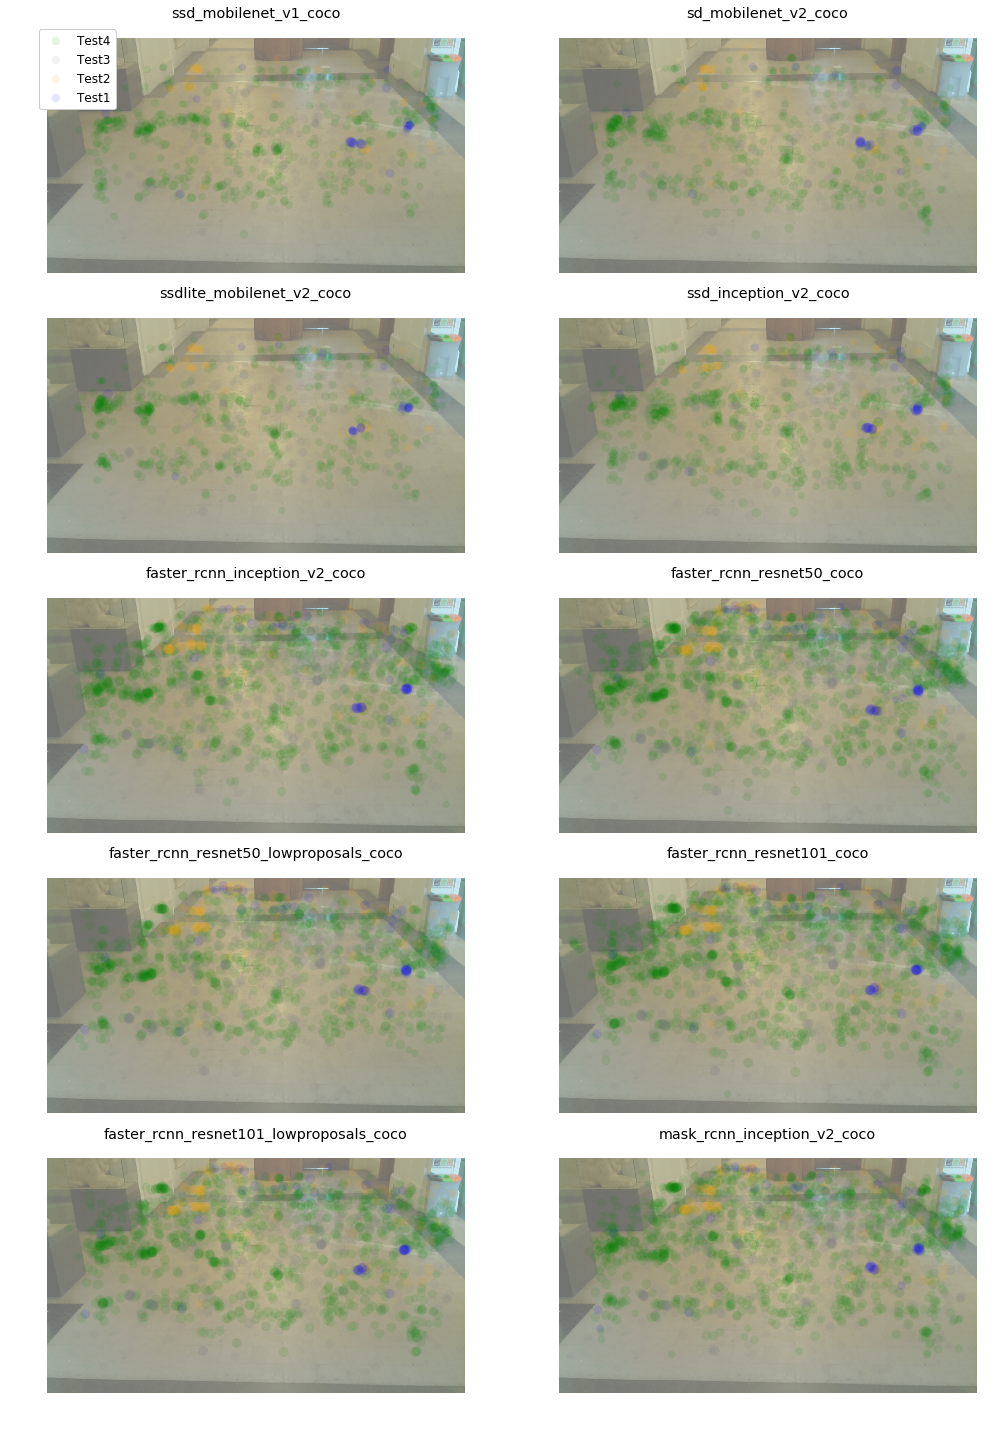

In [82]:
colours = ("blue", "orange", "grey", "green")

frame = cv2.imread(os.path.join('test_inputs', 'test0', '01-03-2015', 'timelapse_05600.jpg'))
h, w = frame.shape[:2]
frame = cv2.resize(frame, (int(w/2), int(h/2)))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
frame[:,:,3] = 50


titles = ['Detections']

cols = 2
rows = int(len(all_centre_results) / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, sharey=True, sharex=True, figsize=(14, 4*rows))

for row in range(rows):
    for col in range(cols):
        index = (row * cols) + col
        model = models[index]
        model_centre_results = all_centre_results[index]
        for test, colour, test_centre_results in zip(reversed(tests), reversed(colours), reversed(model_centre_results)):
            x, y, c = test_centre_results
            axes[row,col].imshow(frame)
            axes[row,col].scatter(x, y, alpha=0.1, c=colour, edgecolors='none', s=c, label=test)
            axes[row, col].set_title(model, size='x-large')
            axes[row, col].axis('off')
            
axes[0,0].legend(['Test4', 'Test3', 'Test2', 'Test1'], facecolor='white', framealpha=1, fontsize='large', loc=2)

fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.15, hspace=0.06)

plt.show()

In [83]:
#fig.savefig('figures/5_5.png', bbox_inches='tight')

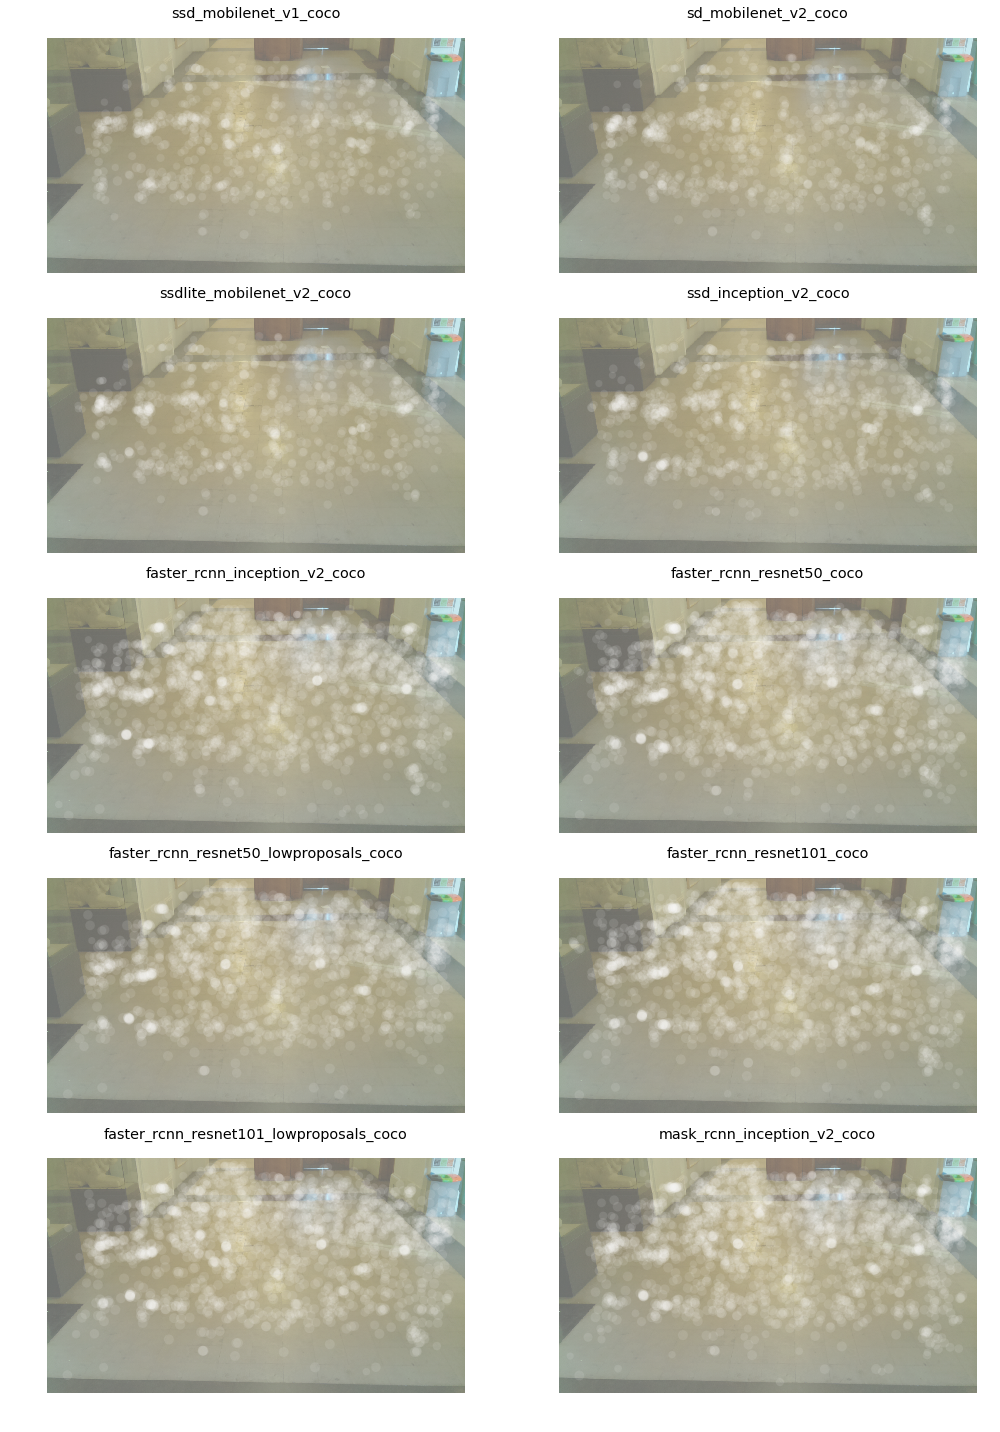

In [27]:
colours = ("white", "white", "white", "white")

frame = cv2.imread(os.path.join('test_inputs', 'test0', '01-03-2015', 'timelapse_05600.jpg'))
h, w = frame.shape[:2]
frame = cv2.resize(frame, (int(w/2), int(h/2)))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
frame[:,:,3] = 50


titles = ['Detections']

cols = 2
rows = int(len(all_centre_results) / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, sharey=True, sharex=True, figsize=(14, 4*rows))

for row in range(rows):
    for col in range(cols):
        index = (row * cols) + col
        model = models[index]
        model_centre_results = all_centre_results[index]
        for test, colour, test_centre_results in zip(reversed(tests), reversed(colours), reversed(model_centre_results)):
            x, y, c = test_centre_results
            axes[row,col].imshow(frame)
            axes[row,col].scatter(x, y, alpha=0.1, c=colour, edgecolors='none', s=c, label=test)
            axes[row, col].set_title(model, size='x-large')
            axes[row, col].axis('off')

fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.15, hspace=0.06)

plt.show()

In [136]:
# Unpack performance results
performance_paths = ['performance_test1.npy',
                     'performance_test2.npy',
                     'performance_test3.npy',
                     'performance_test4.npy', ]
all_performance = []
for perf_path in performance_paths:
    performance = np.load(os.path.join(source, perf_path))[()]
    all_performance.append(performance)

In [139]:
for v in all_performance[0].items():
    print(v)

('ssd_mobilenet_v1_coco', {'triggers': 44, 'av_time': 0.18693213636363637})
('sd_mobilenet_v2_coco', {'triggers': 44, 'av_time': 0.2726270681818182})
('ssdlite_mobilenet_v2_coco', {'triggers': 44, 'av_time': 0.19238611363636363})
('ssd_inception_v2_coco', {'triggers': 44, 'av_time': 0.36078372727272723})
('faster_rcnn_inception_v2_coco', {'triggers': 44, 'av_time': 1.8930659772727274})
('faster_rcnn_resnet50_coco', {'triggers': 44, 'av_time': 5.525509045454545})
('faster_rcnn_resnet50_lowproposals_coco', {'triggers': 44, 'av_time': 2.9677958409090905})
('faster_rcnn_resnet101_coco', {'triggers': 44, 'av_time': 7.349114318181818})
('faster_rcnn_resnet101_lowproposals_coco', {'triggers': 44, 'av_time': 4.86589625})
('mask_rcnn_inception_v2_coco', {'triggers': 44, 'av_time': 10.452249477272726})


In [144]:
np.shape(all_av_detection_rate_results)

(10, 4, 4)

In [148]:
all_av_detection_rate_results[0][0]

(0.49019607843137253,
 0.3333333333333333,
 0.0784313725490196,
 0.058823529411764705)

In [174]:
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
colours2 = cm.rainbow(np.linspace(0,1,10))

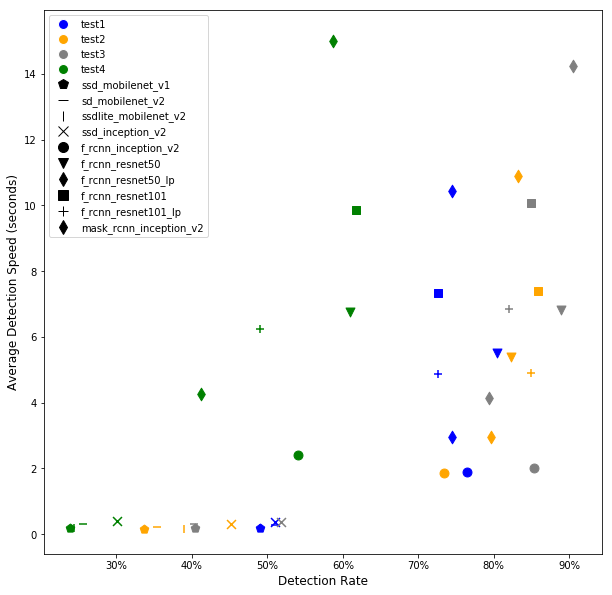

In [212]:
symbols = ["p", "_", "|", "x", "o", "v", "d", "s", "+", "d"]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
for m, (model, test_result) in enumerate(zip(models, all_av_detection_rate_results)):
    for t, (test, model_result) in enumerate(zip(tests, test_result)):
        av_detection_rate = model_result[0]
        test_perf = all_performance[t]
        model_perf = test_perf[model]['av_time']
        
        axes.scatter(av_detection_rate, model_perf, c=colours[t], marker=symbols[m], s=80)
        axes.set_xlabel('Detection Rate', size='large')
        axes.set_ylabel('Average Detection Speed (seconds)', size='large')
        vals = axes.get_xticks()
        axes.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
        
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=cmap,
                          markerfacecolor=c, markersize=10) for c, cmap in zip(colours, tests)]
        legend_elements = legend_elements + [Line2D([0], [0], marker=mark, color='w', markeredgecolor='black', label=mmap,markerfacecolor='black',
                                       markersize=10) for mark, mmap in zip(symbols, models_short)]
        
        axes.legend(handles=legend_elements)
        

plt.show()

In [213]:
#fig.savefig('figures/5_6.png', bbox_inches='tight')